Min gas surface density: 7.61e+00 M_sun/pc^2
Max gas surface density: 1.44e+05 M_sun/pc^2


/tmp/ipykernel_1266/862884922.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('snap200', dpi=300)


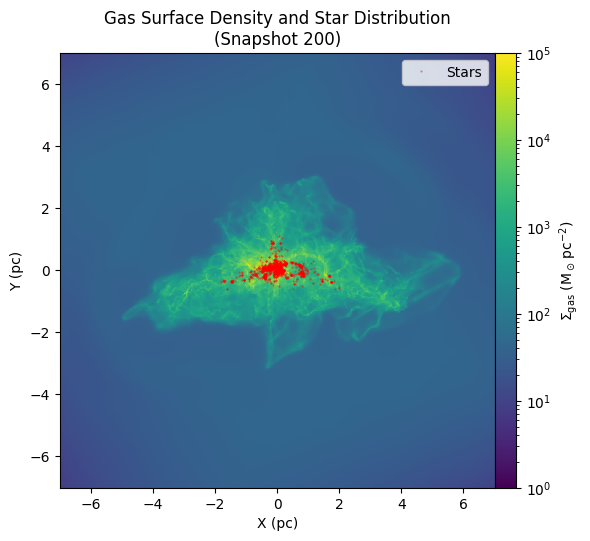

In [19]:
# importing all packages
from matplotlib import pyplot as plt
import numpy as np
from meshoid import Meshoid
import h5py
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# read in snapshot file
snapfile = 'snapshot_200.hdf5'

with h5py.File(snapfile, 'r') as f:
    # gas data
    pt0 = {}
    pt0["Coordinates"] = f["PartType0"]["Coordinates"][:]
    pt0["Masses"] = f["PartType0"]["Masses"][:]
    pt0["SmoothingLength"] = f["PartType0"]["SmoothingLength"][:]

    # star data
    pt5 = {}
    pt5["Coordinates"] = f["PartType5"]["Coordinates"][:] # coordinates of the sink particle

# meshoid code now, first centering the coords before taking the radial cut
pos = pt0['Coordinates']
center = np.median(pos, axis=0)
pos -= center

# now applying the radial cut
MAX_RADIUS = 10 # "perform a cut in galactocentric radius at 40kpc" what is stated from meshoid -> so i changed this to pc and adjusted it to 5. This will allow a 10x10 plot
radius_cut = np.sum(pos*pos, axis=1) < MAX_RADIUS * MAX_RADIUS
pos, mass, hsml = pos[radius_cut], pt0['Masses'][radius_cut], pt0['SmoothingLength'][radius_cut]
center_new = np.average(pos, axis=0, weights=mass) # another recentering
center += center_new
pos -= center_new

# section of getting the principal axes - eigenvectors of the second mass moment matrix
cov_pos = np.cov(pos.T, aweights=mass)
w, coordinate_basis = np.linalg.eigh(cov_pos)
coordinate_basis = coordinate_basis[:,w.argsort()[::-1]] # sorting so the smallest moment axis is the last = z-axis
pos = pos @ coordinate_basis # dot product with each basis vector to get coordinates in new basis
M = Meshoid(pos, mass, hsml)
rmax = 7 # pc
res = 1024
X = Y = np.linspace(-rmax, rmax, res)
X, Y = np.meshgrid(X, Y, indexing='ij')
fig, ax = plt.subplots(figsize=(6,6))
sigma_gas_msun_pc2 = M.SurfaceDensity(M.m,center=np.array([0,0,0]),size=rmax,res=res)

# printing min and max values of the gas data
print(f"Min gas surface density: {np.min(sigma_gas_msun_pc2):.2e} M_sun/pc^2")
print(f"Max gas surface density: {np.max(sigma_gas_msun_pc2):.2e} M_sun/pc^2")

# plotting
p = ax.pcolormesh(X, Y, sigma_gas_msun_pc2, norm=colors.LogNorm(vmin=1,vmax=1e5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.0)
fig.colorbar(p,label=r"$\Sigma_{\rm gas}$ $(\rm M_\odot\,pc^{-2})$",pad=0,cax=cax)
ax.set_aspect('equal')
ax.set_xlabel("X (pc)")
ax.set_ylabel("Y (pc)")

# overplot the stars
star_pos = pt5["Coordinates"]
star_pos -= center # Use the same center as the gas
star_pos = star_pos @ coordinate_basis # Rotate with the same basis

# Filter stars within the plotting extent for efficiency
stars_in_view = (np.abs(star_pos[:,0]) < rmax) & (np.abs(star_pos[:,1]) < rmax)

ax.plot(star_pos[stars_in_view, 0], star_pos[stars_in_view, 1], '.', markersize=1, color='red', alpha=0.5, label='Stars')
ax.legend()

ax.set_title(f'Gas Surface Density and Star Distribution\n(Snapshot 200)')

plt.savefig('snap200', dpi=300)

plt.tight_layout(h_pad=1)
plt.show()